In [1]:
import time
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
# Set your directory path where the images are stored
image_dir = r'D:\ML Projects\CNN Classification\W4A2\Classifier\RealWaste'
data = []

# Iterate through each type of waste folder
for waste_type in os.listdir(image_dir):
    type_path = os.path.join(image_dir, waste_type)
    if os.path.isdir(type_path):
        # Iterate through each image in the waste type folder
        for image_name in os.listdir(type_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats as needed
                image_path = os.path.join(type_path, image_name)
                data.append({
                    'file_name': image_name,
                    'path': image_path,
                    'type': waste_type
                })

# Shuffle the dataset
np.random.seed(42)  # For reproducibility
np.random.shuffle(data)

# Create lists for X and y
X = [entry['path'] for entry in data]  # Image paths
y = [entry['type'] for entry in data]   # Corresponding labels

# Encode the labels as integers and store the names
unique_classes = list(set(y))
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_encoded = [class_mapping[label] for label in y]
y_names = [unique_classes[label] for label in y_encoded]  # Store original names corresponding to encoded labels

# Split the data into training (60%), validation (20%), and testing (20%)
train_x, temp_x, train_y, temp_y, train_y_names, temp_y_names = train_test_split(X, y_encoded, y_names, test_size=0.4, random_state=42)
val_x, test_x, val_y, test_y, val_y_names, test_y_names = train_test_split(temp_x, temp_y, temp_y_names, test_size=0.5, random_state=42)

# Create a dataset dictionary
dataset = {
    'train': {'X': train_x, 'y': train_y, 'y_names': train_y_names},
    'validation': {'X': val_x, 'y': val_y, 'y_names': val_y_names},
    'test': {'X': test_x, 'y': test_y, 'y_names': test_y_names},
    'class_mapping': class_mapping  # Include class mapping for reference
}

# Save the dataset to a JSON file
json_file_path = 'waste_images_dataset_split.json'
with open(json_file_path, 'w') as json_file:
    json.dump(dataset, json_file, indent=4)

print(f"Dataset split into train, validation, and test sets and saved to {json_file_path}.")


Dataset split into train, validation, and test sets and saved to waste_images_dataset_split.json.


Image shape: (277, 277, 3)
y = 1. It's a Paper picture.


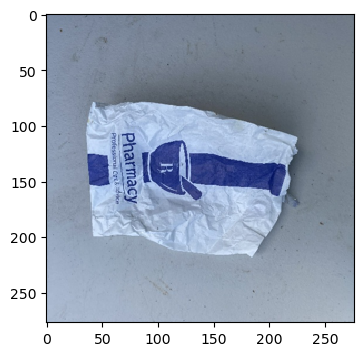

In [3]:
# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Example of using the training set
train_data = dataset['train']
train_x = train_data['X']  # Image paths
train_y = train_data['y']   # Labels

# Choose an index to display an image
index = 389
num_px = 277

# Load the image from the specified path
image_path = train_x[index]
image = Image.open(image_path).resize((num_px, num_px))  # Resize as necessary
plt.imshow(image)

# Print the shape of the image
print("Image shape:", np.array(image).shape)

# Get the corresponding label
label = train_y_names[index]
label_number = train_y[index]
print("y = " + str(label_number) + ". It's a " + label + " picture.")
classes = ["Glass", "Plastic", "Metal", "Miscellaneous Trash", "Cardboard", "Food Organics", "Textile Trash", "Paper", "Vegetation"]


In [4]:
# Load the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# Extract the training and testing data
train_data = dataset['train']
test_data = dataset['test']

# Set the number of pixels for resizing images
num_px = 277  # Example pixel size for resizing images

# Prepare the data for exploration with names included
train_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255. for image_path in train_data['X']])
train_y = np.array(train_data['y'])
train_y_names = np.array(train_data['y_names'])  # Add names for training set

test_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255. for image_path in test_data['X']])
test_y = np.array(test_data['y'])
test_y_names = np.array(test_data['y_names'])  # Add names for testing set

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False, categories='auto')
train_y_one_hot = encoder.fit_transform(train_y.reshape(-1, 1))  # Reshape for encoder
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Use transform on test set

# Explore your dataset
m_train = train_x.shape[0]
num_px = train_x.shape[1]  # Assuming square images
m_test = test_x.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x.shape))
print("train_y shape (original): " + str(train_y.shape))
print("train_y shape (one-hot): " + str(train_y_one_hot.shape))
print("test_x shape: " + str(test_x.shape))
print("test_y shape (original): " + str(test_y.shape))
print("test_y shape (one-hot): " + str(test_y_one_hot.shape))


Number of training examples: 2851
Number of testing examples: 951
Each image is of size: (277, 277, 3)
train_x shape: (2851, 277, 277, 3)
train_y shape (original): (2851,)
train_y shape (one-hot): (2851, 9)
test_x shape: (951, 277, 277, 3)
test_y shape (original): (951,)
test_y shape (one-hot): (951, 9)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def CNN_model(input_shape, num_classes, learning_rate=0.001):
    """
    Implements a more complex Convolutional Neural Network to classify images with added layers and dropout.

    Arguments:
    input_shape -- shape of the input images (height, width, channels)
    num_classes -- number of output classes (for binary classification, num_classes=1)
    learning_rate -- learning rate of the optimization

    Returns:
    model -- a compiled Keras model ready for training
    """
    model = models.Sequential()
    
    # Convolutional Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Convolutional Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))
    
    # Convolutional Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Fully Connected Block
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax'))
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

    


In [6]:
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y_one_hot.shape)

Shape of train_x: (2851, 277, 277, 3)
Shape of train_y: (2851, 9)


In [7]:
# You can keep train_y and train_y_names as is:
train_y = train_y.reshape(2851,)  # Keep it 1D for single label representation
train_y_names = train_y_names.reshape(2851,)  # Keep it 1D for single label representation

# You do not need to reshape test_y and test_y_names unless you have a specific reason to do so
test_y_names = test_y_names.reshape(951,)  # Keep it 1D for single label representation
test_y = test_y.reshape(951,)  # Keep it 1D for single label representation

# If you also want one-hot encoding for test_y:
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # Convert to one-hot for test set

# Verify shapes
print("train_y shape:", train_y.shape)
print("train_y_names shape:", train_y_names.shape)
print("train_y_one_hot shape:", train_y_one_hot.shape)
print("test_y shape:", test_y.shape)
print("test_y_names shape:", test_y_names.shape)
print("test_y_one_hot shape:", test_y_one_hot.shape)


train_y shape: (2851,)
train_y_names shape: (2851,)
train_y_one_hot shape: (2851, 9)
test_y shape: (951,)
test_y_names shape: (951,)
test_y_one_hot shape: (951, 9)


In [ ]:
# Define model parameters
input_shape = (277, 277, 3)  # Example input shape (height, width, channels)
num_classes = 9  # Binary classification (e.g., cat vs. not cat)

# Initialize and compile model with binary crossentropy
model = CNN_model(input_shape, num_classes, learning_rate=0.001)

model.summary()

C:\Users\MSI KATANA\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 275, 275, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 275, 275, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 273, 273, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 136, 136, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 136, 136, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 134, 134, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 134, 134, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 132, 132, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 66, 66, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 66, 66, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 31, 31, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    31,490,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 31,813,801 (121.36 MB)

 Trainable params: 31,812,585 (121.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [10]:
# Train the model
history = model.fit(train_x, train_y_one_hot, epochs=10, batch_size=32, validation_data=(test_x, test_y_one_hot))

Epoch 1/10
39/90 ━━━━━━━━━━━━━━━━━━━━ 2:22 3s/step - accuracy: 0.1957 - loss: 3.1071

KeyboardInterrupt: 

['Glass', 'Plastic', 'Metal', 'Miscellaneous Trash', 'Cardboard', 'Food Organics', 'Textile Trash', 'Paper', 'Vegetation']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


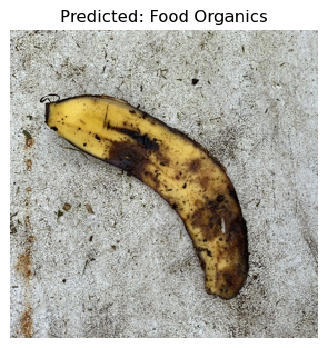

Predicted class index: 5
Predicted class name: "Food Organics"


In [103]:
def predict_class(image_path, model, class_names, num_px=277):
    """
    Function to predict the class of an image and return the class name, while displaying the image.
    
    Parameters:
    - image_path: str, path to the image to be predicted.
    - model: trained Keras model.
    - class_names: list of str, names of classes corresponding to model output indices.
    - num_px: int, pixel dimension to resize the image to (assuming square images).

    Returns:
    - predicted_class_name: str, name of the predicted class.
    """
    # Load and preprocess the image
    image = Image.open(image_path).resize((num_px, num_px))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_input = image_array.reshape((1, num_px, num_px, 3))  # Add batch dimension

    # Predict using the model
    predictions = model.predict(image_input)
    
    # Get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    
    # Retrieve the class name from class_names using the predicted index
    predicted_class_name = class_names[predicted_class_index]

    # Display the image with the predicted class name
    plt.imshow(image_array)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    # Print the prediction result
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: \"{predicted_class_name}\"")
    
    return predicted_class_name

# Example usage:
# Assuming `train_y_names` holds the names of the classes corresponding to indices 0–8.
print(classes)
image_path = "D:\ML Projects\CNN Classification\W4A2\Classifier\images\Food Organics.jpg"  # Replace with your image path
predicted_class_name = predict_class(image_path, model, classes)
